In [1]:
import numpy as np

Hey guys, welcome to math. A lot of what is expected of Aeros here is knowing orbits and how they work. The goal of this tutorial is to give you the basics you need to get started and participate in the proposal process.

The skills you should by the end of this:

1) Equations of motion of an orbit

2) Vector math in Python

3) Orbital Elements

4) Two Line Elements and the SGP4 standard

5) Intro to rotations and relevant refference frames

6) Models of disturbances and how they work

# Equations of Motion

To begin, the fundamental equation of motion for an orbiting spacecraft.

\begin{equation}
acceleration = \ddot{\vec{r}} = -\frac{\mu}{||\vec{r}||^{3}}*\vec{r}
\end{equation}

\begin{equation}
velocity = \int \ddot{\vec{r}}dx + \vec{v_{0}}
\end{equation}

\begin{equation}
position = \int \dot{\vec{r}}dx  + \vec{r_{0}}
\end{equation}




Where $\vec{r}$ represents position and $\ddot{\vec{r}}$ represents acceleration, aka the second derivative of position. $\mu$ is called the "Gravitational Parameter". For earth it is 398600$\frac{km^3}{sec}$. This value is entirely a function of the mass of the body you are orbiting.

So how do we use this in code to plot an orbit?

# Vector Math in Python

This tutorial will have Python math sprinkled all over it ideally, so here are the basics of what that looks like.

In [2]:
# This is a comment, denoted by the # Symbol

#Scalar math

#addition
x = 1 + 2
print(x)

#powers
x = 4**2 #4 to the power 2
print(x)

x = np.sqrt(16) # square root, aka 16**0.5
print(x)

x = np.exp(-1) # e to the power -1, using numpy
print(x)



3
16
4.0
0.36787944117144233


Python does not have vectors natively, but thankfully the library "numpy" exist. It is so ubiquitous that it is basically cannon at this point. for some reason matrices and vectors are reffered to as "arrays" within numpy. 

In [3]:
import numpy as np

#Basic matrix addition

A = np.array([[1, 3, 3],
              [2, 4, 5],
              [8, 7, 6]])
print('A:')
print(A)

B = np.identity(3)
print('B:')
print(B)

C = A + B
print('A + B:')
print(C)

A:
[[1 3 3]
 [2 4 5]
 [8 7 6]]
B:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
A + B:
[[2. 3. 3.]
 [2. 5. 5.]
 [8. 7. 7.]]


Now say you want to solve a system of equations for $x$ when $y = A*x$. The solution is $x = A^{-1}*y$. Implementing this in Python looks like this.

In [4]:
y = np.array([1, 6, 8])

x = np.linalg.inv(A)@y

print(x, end = ' ')
print('How yucky.')

[ 1.63157895 -3.78947368  3.57894737] How yucky.


The @ operator performs matrix multiplication, the normal * operator does element wise multiplication. This is a difference between Matlab and Python.

So, now that we have the basics of math in python, how might we go back to our equations of motion?

In [5]:
def gravitational_acceleration(r):
    mu = 398600
    acceleration = -mu*r/np.linalg.norm(r)**3
    return acceleration
    
r0 = np.array([0, 0, 6378 + 400])
print(gravitational_acceleration(r0))
    

[0.         0.         0.00511659]


Notice I defined r0 to have a magnitude of 6378 + 400. 6378 is the radius of the earth in $km$ and 400 is a standard orbital altitude. Notice that we are using $km$, not meters and that the acceleration is in $km/sec^2$. Later, for velocity we will use $km/sec$. These units are much easier to work with on these scales than meters.

Lets say you have a spacecraft with an initial position and velocity, lets plot its orbit for a while. For this we will need to import a library to solve ordinary diferential equations. You will get into this more in your classes, for now just learn how to use it and ask us questions.

In [7]:
from scipy.integrate import ode

mu = 398600
r0 = np.array([0, 0, 6378 + 400])
v0 = np.array([0, np.sqrt(mu/np.linalg.norm(r0)), 0]) #equation for velocity of a circular orbit = sqrt(mu/r)

t0 = 0 #initial time
state0 = np.hstack([r0, v0])

def equations_of_motion(t, state, mu): #state derivative function must take time, the state, and constants as parameters
    position = state[0:3]
    velocity = state[3:6]
    
    velocity_derivative = -mu*position/np.linalg.norm(position)**3 #aka acceleration
    position_derivative = velocity
    
    return np.hstack([position_derivative, velocity_derivative])

solver = ode(equations_of_motion) #pass a function that calculates the derivatives of all the states
solver.set_integrator('lsoda') #dont worry about this, you get to pick which fortran algorythm you want to use. Theres a list, they all work.
solver.set_initial_value(state0, t0) #set initial state and time
solver.set_f_params(mu) #set the constants that we pass to the function

newstates = []
times = []

simulation_time = 60*60 #1 hour
dt = 1
while solver.successful() and solver.t < simulation_time:
    newstates.append(solver.y) #y is the state of the simulation [pos, vel]
    times.append(solver.t) #t is the time of the simulation in seconds
    solver.integrate(solver.t + dt)
    
newstates = np.vstack(newstates)
times = np.hstack(times)

print(newstates[0])
    

[   0.            0.         6778.            0.            7.66863143
    0.        ]


Now to plot the orbit.

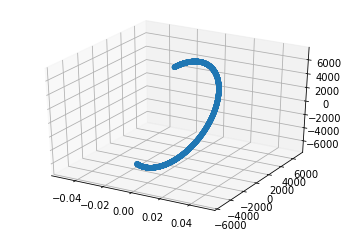

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter(newstates[:,0], newstates[:,1], newstates[:,2])
plt.show()

Wow, beautiful.

# Orbital Elements

So thats the nitty gritty on how to propagate an orbit. That is the most numerical and functional way, there is another that is more elegant and strange. Welcome to Keplerian Elements.

Every orbit can be described by 6 parameters. These are $Semimajor Axis$, $Eccentricity$, $True Anomaly$, $Inclination$, $Right Accension$, and $Argument of Perigee$.

This is a super hand-wavy description. For now it is important to know what they are and to know how to convert between them. The textbooks in lab will have more satisfying explanations than what I can write.

#### Semimajor Axis
This is simply the average of the altitude at periapsis and the altitude at apoapsis.

#### Eccentricity
This is the normalized difference between the apoapsis and periapsis, basically how circular the orbit is. 0 is perfectly circular, 1 means you are flying out of the system.

#### True Anomaly
This is the angular position of your spacecraft along its orbit. See $\theta$ in the image below.

#### Inclination, Right Ascention, Argument of perigee
These are hard to visualize. You can google it. The only one that is important to understand conceptually is inclination. Inclination is the angle between the plane of your orbit and the earths pole. An equatorial orbit is an inclination of 0.

These are all angles, they represent the orientation of your orbit in 3D space.

![Semimajor axis and stuff](orbit.png)

## Conversion Between State Vector and Orbital Elements

You will 100% need these conversions. I will leave it as a homework assignment for you to write these functions yourself. You can find the algorythm to convert a state vector to orbital elements on page 196 in Orbital Mechanics for Engineering Students. For the converse conversion, look at the section on page 216 for help. Ideally I want to help yall out with this stuff in person.

# Two Line Elements

Real spacecraft exist and people usually want to know where they are. Thankfully the government provides a free and international service for tracking and identifying space objects that are larger than 10cm. If you visit https://www.celestrak.com/NORAD/elements/ you cand find the Two Line Elements for a bunch of popular spacecraft. Also from now on we are calling them TLE's.

Understanding TLEs and knowing how to use them is essential for spacecraft operations. We use programs such as Orbitron or Macdoppler which deal with TLEs under the hood.

#### Things to Know
Some important things to know about TLE's:
1) They expire every two weeks. TLE's describe an ideal keplerian orbit and because of perturbations that are unpredictable this becomes less and less accurate as time goes on.

2) The are accurate to about +/- 3 km. They are usually better the fresher a TLE is.

3) They are meant to be interpreted by the spg propagator. Not many people know what hte actual code looks like, but it is open source on just about every programming language.

4) You must use a historical TLE if you want to know where a spacecraft was more than two weeks in the past. Do not use the current TLE for the ISS if you want to know if it was over your house during new years of 2007.


#### What does one look like? Sorry you asked...
A TLE is literally two lines of text compressed in the most contrived way possible. The format was originally created when computer memory was extremely limited and so now we have to deal with it. This is what a TLE looks like:

![TLE](example_tle.png)

And this is the table explaining what it means character by character.

![HOLY CRAP!](tle_chart.png)

I think that the only super usefull thing to get out of a TLE from sight at the moment is the launch date, ID, and the date at which the TLE was taken. Here is a beautiful annotation.

![Very nice](tlew.png)


## So how do I use this SGP4 thing?
Yeah sure. SGP stands for "simplified perturbations model". So it does actually account for perturbations a little, mostly drag. Heres how you would go about using it in python.


In [7]:
from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv
import datetime

line1 = "1 41788U 16059F   19219.20080378  .00004599  00000-0  69683-3 0  9991"
line2 = "2 41788  98.2414 295.3950 0027599 208.1768 151.7974 14.74406613153307"

spacecraft = twoline2rv(line1, line2, wgs84)

#You can see this TLE was taken on the 219th day of 2019. I will pick a date close to that
#I will use a datetime object to do the gross math for me

#starting at newyears on 2019 and then adding 223 days to it.
date = datetime.datetime(year = 2019, month = 1, day = 1) + datetime.timedelta(days = 223)

print(target_date)

position, velocity = spacecraft.propagate(date.year, date.month, date.day, date.hour, date.minute, date.second)

print("Position   [km]: ", position)
print("Velocity [km/s]: ", velocity)



2019-08-12 00:00:00
Position   [km]:  (169.45365663130372, 1670.5715595517124, -6820.732271453856)
Velocity [km/s]:  (3.9037422940968374, -6.268371283977405, -1.4581398072831964)
